In [87]:
import astropy
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import photutils
import sys
sys.path.append("../src/")
from plot_utils import show_imstat, plot_line, plot_zscale_image

import numpy as np

from astropy.visualization import ZScaleInterval
from astropy import stats as astrostats

import scipy
import scipy.stats as scistats

from astropy.nddata import CCDData

In [2]:
import fitsio

In [3]:
from pathlib import Path

In [4]:
rawdir = Path("/global/cfs/cdirs/desi/users/adamyers/wiro/raw/20221003")
reduceddir = Path("/global/cfs/cdirs/desi/users/adamyers/wiro/reduced/20221003")

In [12]:
imfile = "a143_zbf.fit"
image = fitsio.read(reduceddir / imfile)

In [13]:
fitsio.read_header(reduceddir / imfile)


SIMPLE  =                    T / conforms to FITS standard
BITPIX  =                  -64 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                 4096 / 
NAXIS2  =                 4096 / 
EXTEND  =                    T / 
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
OBSERVAT= 'WIRO'               / 
OBJNAME = 'XMM-LSS 3'          / 
UTC     = '08:47'              / 
LSTOBS  = '02:35'              / Local Sidereal Time
TELRA   = '02:19:32.78'        / 
TELDEC  = '-4:-50:-25.-5'      / 
EPOCH   =               2000.0 / 
HA      =              4.04752 / 
AIRMASS =                 1.44 / 
OFFSETHA=                 29.7 / 
OFFSTDEC= '-78.0'              / 
TELFOCUS=                 0.08 / 
OUTTEMP =                  0.0 / 
OUTHUMID=                  0.0 / 
BAROPRES=                  0.0 / 
WINDDIR =                  0.0 / 
WINDS

Text(0.5, 1.0, 'a143_zbf.fit overscan sub, trimed | bias sub | flat field corrected')

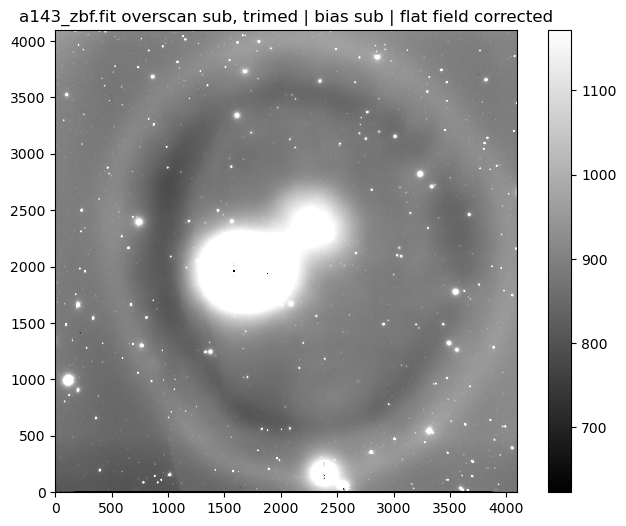

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
plot_zscale_image(image, ax, cmap="gray")
ax.set_title(f"{imfile} overscan sub, trimed | bias sub | flat field corrected")

In [24]:
from photutils.background import Background2D, MedianBackground, MADStdBackgroundRMS
from astropy.stats import SigmaClip

sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(image, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, 
                   bkg_estimator=bkg_estimator)
sigma_clip = SigmaClip(sigma=3.0)
bkgrms = MADStdBackgroundRMS(sigma_clip)

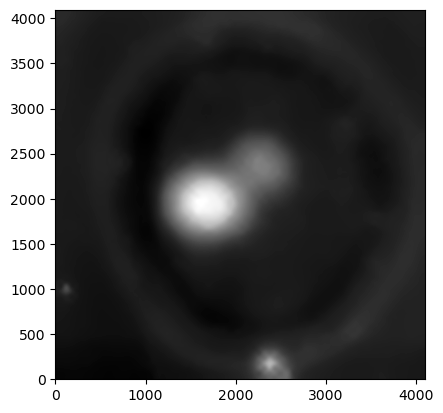

In [25]:
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',
           interpolation='nearest')

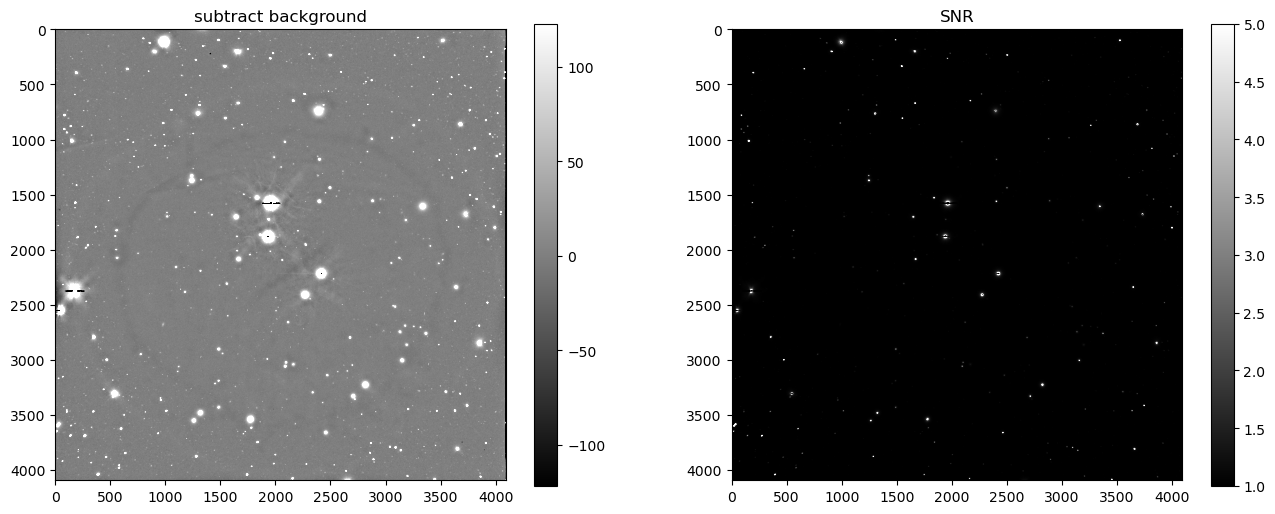

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_zscale_image(np.transpose(image - bkg.background), ax[0], cmap="gray", vmin=0, vmax=150)
ax[0].set_title("subtract background")
ax[0].invert_yaxis()
plot_zscale_image(np.transpose(image / bkg.background), ax[1], cmap="gray", vmin=1, vmax=5)
ax[1].set_title("SNR")
ax[1].invert_yaxis()

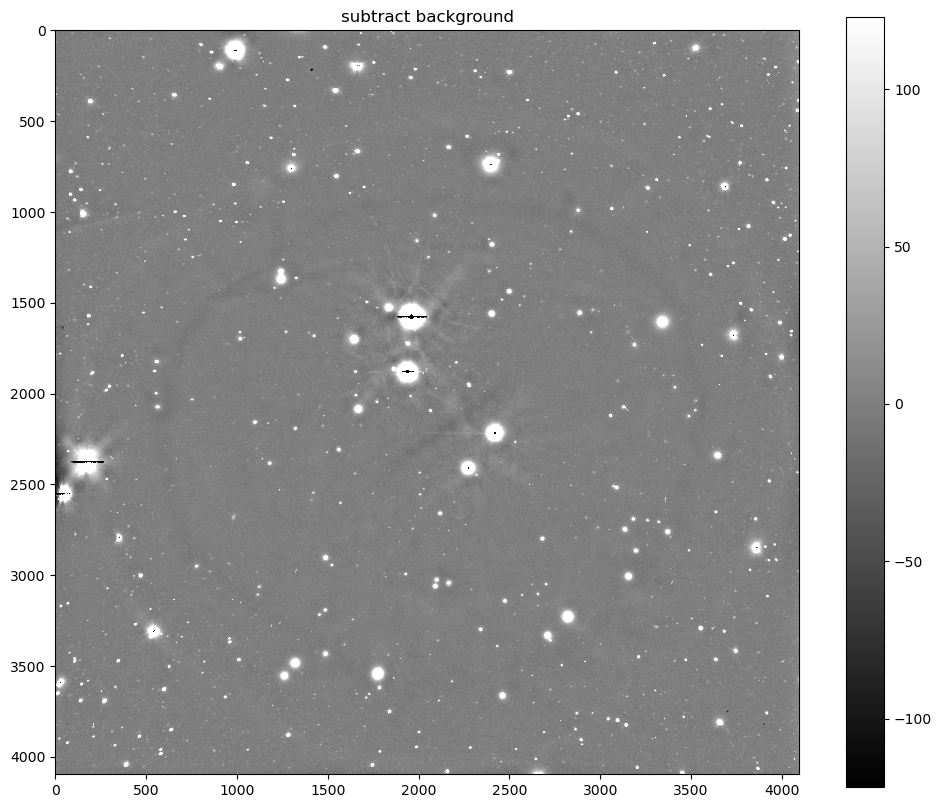

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plot_zscale_image(np.transpose(image - bkg.background), ax, cmap="gray", vmin=0, vmax=150)
ax.set_title("subtract background")
ax.invert_yaxis()

In [66]:
np.mean(bkg.background_rms)

21.055043199054534

In [67]:
bkg.background_rms_median

19.497487683674706

In [64]:
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(image, sigma=3.0)  
print((mean, median, std)) 

(892.600362581507, 891.9654811869224, 40.501754588201955)


In [68]:
from photutils.detection import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5*std)  
sources = daofind(image - bkg.background)

In [83]:
faint_idx = np.argpartition(sources["mag"], -50)[-30:-20]

In [84]:
sources[faint_idx]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
664,1752.3587839699635,3804.3519320447576,0.8274281742824376,0.18780073192290236,-0.20514375858257128,25,0.0,267.5625609171026,1.0612295545600123,-0.06452334075122412
280,2367.31293434773,1688.5238618034318,0.7597147957757829,-0.08015885851347446,-0.0709585306943501,25,0.0,247.8250446394061,1.050052552060987,-0.05302758695812079
336,1555.8665178793103,1955.5759684070074,0.28795643622279177,-0.9337704323964389,-0.8197243892879775,25,0.0,3801.9395693512515,1.0036221010199529,-0.003925541145405271
150,3477.6304790089584,820.6166697735555,0.381412981095148,0.012979782191697903,0.9683399757263443,25,0.0,498.54263297635316,1.0449912705618203,-0.04778165635053756
230,219.19403060390323,1414.999033885329,0.9295635399143607,0.9114801893616328,-0.12349976540278959,25,0.0,21.25586777682861,1.0213630830190725,-0.022950390772432765
540,2094.114272320652,3083.057668844716,0.9606253630880662,-0.43980184126761973,-0.3805619914150668,25,0.0,295.33497269471945,1.0247466474886597,-0.026541265435346337
227,3531.2239160405984,1353.0967473498738,0.8917915976084457,0.22964442960100637,-0.2739135199240738,25,0.0,272.99047254208597,1.006813142992281,-0.007372190541446957
539,237.47530581322843,3084.5970855833807,0.4024241480241093,0.6825865051836099,0.8893296269347496,25,0.0,583.543930784136,1.0274045693926752,-0.02935373230477383
536,2513.7327348358835,3070.060917761874,0.4332381491749051,0.6759931568391314,0.9755293990525528,25,0.0,505.30572730756705,1.072843435541059,-0.07634087052126184


In [85]:
faint_sources = sources[faint_idx]

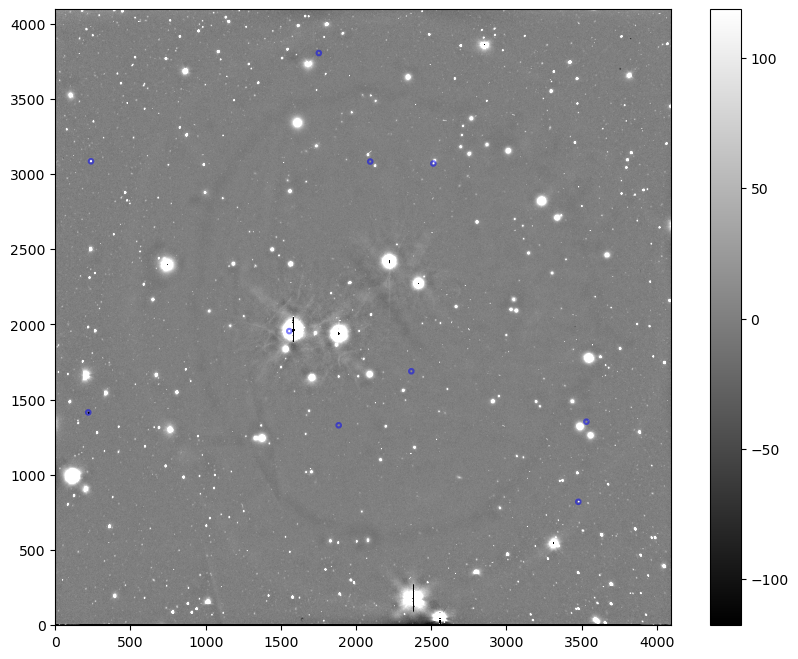

In [86]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((faint_sources['xcentroid'], faint_sources['ycentroid']))
apertures = CircularAperture(positions, r=15.)
norm = ImageNormalize(stretch=SqrtStretch())
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
plot_zscale_image(image-bkg.background, ax, cmap="gray")
# plt.imshow(image - bkg.background, cmap='Greys', origin='lower',
#           )
apertures.plot(color='blue', lw=1.5, alpha=0.5)